In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import astropy
from astropy import stats
import math

import scipy
from scipy import stats

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special

import figurefirst as fifi

# Step 1: Calculate max change at various lags

In [3]:
def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list

In [4]:
def _circfuncs_common(samples, high, low, nan_policy='propagate'):
    # Ensure samples are array-like and size is not zero
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.asarray(np.nan), np.asarray(np.nan), None

    # Recast samples as radians that range between 0 and 2 pi and calculate
    # the sine and cosine
    sin_samp = sin((samples - low)*2.*pi / (high - low))
    cos_samp = cos((samples - low)*2.*pi / (high - low))
    #sin_samp=sin(samples)
    #cos_samp=cos(samples)
    mask = None
    return samples, sin_samp, cos_samp, mask


def mycircstd(samples, high=360, low=0, axis=None, nan_policy='propagate'):

    samples, sin_samp, cos_samp, mask = _circfuncs_common(samples, high, low,
                                                          nan_policy=nan_policy)
    if mask is None:
        sin_mean = sin_samp.mean(axis=axis)  # [1] (2.2.3)
        cos_mean = cos_samp.mean(axis=axis)  # [1] (2.2.3)
    else:
        nsum = np.asarray(np.sum(~mask, axis=axis).astype(float))
        nsum[nsum == 0] = np.nan
        sin_mean = sin_samp.sum(axis=axis) / nsum
        cos_mean = cos_samp.sum(axis=axis) / nsum
    # hypot can go slightly above 1 due to rounding errors
    with np.errstate(invalid='ignore'):
        R = np.minimum(1, hypot(sin_mean, cos_mean))  # [1] (2.2.4)

    #res = sqrt(-2*log(R))
    #if not normalize:
    #    res *= (high-low)/(2.*pi)  # [1] (2.3.14) w/ (2.3.7)
    res = np.sqrt(2 * (1 -R))
    
    return res

def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list


def new_temporal_analysis (dir_df, speed_df, lagarray, method='forward'):
    '''
# This function takes a single starting value from a column of directional data in a pandas df or np array
# and returns a list of values at each desired lag.

# Note, directional data must be between 0-360 degrees.
# Need to convert data if in radians and/or if it goes from -180 to 180.


#inputs: df - one column or array of directional data bounded between 0-360
#        startval - first point of wind data that you want to analyze
#        lagarray - array of time lags that you wish to calculate. a lag of 1=.1 sec
#        method - time direction in which lags are calculated 
#        options are forward, backward, average, max, or min. 
#             if no method is selected, forward is the default
    '''
    
    avg_d_list=np.zeros((len(lagarray)))
    avg_s_list=np.zeros((len(lagarray)))
    std_d_list=np.zeros((len(lagarray)))
    std_s_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(dir_df,startval,lag): 
    #compute the standard deviation backwards if the start value+lag will be greater than the length of the df
        if (startval+i)>=len(df): 
            dirchunk=dir_df.iloc[(startval-i):startval]
            speedchunk=speed_df.iloc[(startval-i):startval]
            avg_d_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            avg_s_list[j]= np.mean(speedchunk)
            std_d_list[j]=mycircstd(dirchunk, high=360, low=0) 
            std_s_list[j]=np.std(speedchunk)   
         
    
    def fixangle(angle):
        if angle>=180:
            angle=360-angle
        return angle
    
    
    for i in lagarray:
        
        if method=='forward': #currently only forward - will eventually update?
            startval=int(dir_df.sample(1).index.to_numpy()) #get a random start value for each lag
            checkforwardbounds(dir_df,startval,i)
            dirchunk=dir_df.iloc[startval:(startval+i)]
            speedchunk=speed_df.iloc[startval:(startval+i)]
            avg_d_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            avg_s_list[j]= np.mean(speedchunk)
            std_d_list[j]=mycircstd(dirchunk, high=360, low=0) 
            std_s_list[j]=np.std(speedchunk)
            
        j=j+1
    return avg_d_list, avg_s_list, std_d_list, std_s_list

In [ ]:
df1=pd.read_hdf('Github repo/raw_data_for_me/small_10.20.20_maskedgpsdata.hdf')
df2=pd.read_hdf('Github repo/raw_data_for_me/small_7.7.21_maskedgpsdata.hdf')
df3=pd.read_hdf('Github repo/raw_data_for_me/small_9.26.21_maskedgpsdata.hdf')
df4=pd.read_hdf('Github repo/raw_data_for_me/small_10.29.21_maskedgpsdata.hdf')
df5=pd.read_hdf('Github repo/raw_data_for_me/small_10.30.21_maskedgpsdata.hdf')
df6=pd.read_hdf('Github repo/raw_data_for_me/small_1.8.22_maskedgpsdata.hdf')
df7=pd.read_hdf('Github repo/raw_data_for_me/small_1.11.22_maskedgpsdata.hdf')
df8=pd.read_hdf('Github repo/raw_data_for_me/small_1.15.22_maskedgpsdata.hdf')
df9=pd.read_hdf('Github repo/raw_data_for_me/small_4.30.22_maskedgpsdata.hdf')
df10=pd.read_hdf('Github repo/raw_data_for_me/small_5.1.22_maskedgpsdata.hdf')
df11=pd.read_hdf('Github repo/raw_data_for_me/small_5.2.22_maskedgpsdata.hdf')
df12=pd.read_hdf('Github repo/raw_data_for_me/small_6.1.22_maskedgpsdata.hdf')
df13=pd.read_hdf('Github repo/raw_data_for_me/small_6.3.22_maskedgpsdata.hdf')
df14=pd.read_hdf('Github repo/raw_data_for_me/small_6.7.22_maskedgpsdata.hdf')
df15=pd.read_hdf('Github repo/raw_data_for_me/small_6.8.22_maskedgpsdata.hdf')
df16=pd.read_hdf('Github repo/raw_data_for_me/small_6.22.22_maskedgpsdata.hdf')

# Calculate lags and make a df for each data collection

In [ ]:
df=df2

In [ ]:
loglags=np.arange(300,6300,300) 
#lags from 0-10mins, 30 sec intervals -- excluding lag zero since there is no standard dev over a period of 0
totalrows=np.arange(0,int(len(df)/10000))
listoflists_avgd = np.empty((len(totalrows), 0)).tolist()
listoflists_avgs = np.empty((len(totalrows), 0)).tolist()
listoflists_stdd = np.empty((len(totalrows), 0)).tolist()
listoflists_stds = np.empty((len(totalrows), 0)).tolist()

In [ ]:
i=0
for j in totalrows:
    listoflists_avgd[i], listoflists_avgs[i], listoflists_stdd[i], listoflists_stds[i] = new_temporal_analysis(df.D_2, df.U_2, lagarray=loglags, method='forward')
    i=i+1

In [ ]:
#convert to df
df_avgd=pd.DataFrame(listoflists_avgd, index=range(len(listoflists_avgd)), columns=loglags)
df_avgs=pd.DataFrame(listoflists_avgs, index=range(len(listoflists_avgs)), columns=loglags)
df_stdd=pd.DataFrame(listoflists_stdd, index=range(len(listoflists_stdd)), columns=loglags)
df_stds=pd.DataFrame(listoflists_stds, index=range(len(listoflists_stds)), columns=loglags)


In [ ]:
test_ddf=pd.DataFrame(columns = ['speed_std', 'direction_std', 'speed_avg', 'direction_avg'])

i=0


for k in df_avgd.index:
    xtra = {'speed_std': df_stds.iloc[k,:], 
           'direction_std': df_stdd.iloc[k,:],
           'speed_avg': df_avgs.iloc[k,:], 
           'direction_avg': df_avgd.iloc[k,:],
            }
    test_ddf= test_ddf.append(pd.DataFrame(xtra))
i=i+1

In [ ]:
test_ddf.reset_index(inplace=True)
test_ddf.rename(columns={'index':'time'}, inplace=True)

In [ ]:
test_ddf[['environment']]=.4
test_ddf[['group']]=2
test_ddf.direction_std=test_ddf.direction_std*180/np.pi #make it degrees again
test_ddf.time=test_ddf.time*.1 #fix the time to be accurate 

In [ ]:
test_ddf 

In [ ]:
plt.scatter(test_ddf.speed_avg, test_ddf.speed_std)

In [ ]:
test_ddf.to_hdf('7.7.21_temporal.hdf', key='/windgps')

# Looking at all lagged dataframes

In [35]:
t1=pd.read_hdf('dfs_for_temporalregression/10.20.20_temporal.hdf')
t2=pd.read_hdf('dfs_for_temporalregression/7.7.21_temporal.hdf')
t3=pd.read_hdf('dfs_for_temporalregression/9.26.21_temporal.hdf')
t4=pd.read_hdf('dfs_for_temporalregression/10.29.21_temporal.hdf')
t5=pd.read_hdf('dfs_for_temporalregression/10.30.21_temporal.hdf')
t6=pd.read_hdf('dfs_for_temporalregression/1.8.22_temporal.hdf')
t7=pd.read_hdf('dfs_for_temporalregression/1.11.22_temporal.hdf')
t8=pd.read_hdf('dfs_for_temporalregression/1.15.22_temporal.hdf')
t9=pd.read_hdf('dfs_for_temporalregression/4.30.22_temporal.hdf')
t10=pd.read_hdf('dfs_for_temporalregression/5.1.22_temporal.hdf')
t11=pd.read_hdf('dfs_for_temporalregression/5.2.22_temporal.hdf')
t12=pd.read_hdf('dfs_for_temporalregression/6.1.22_temporal.hdf')
t13=pd.read_hdf('dfs_for_temporalregression/6.3.22_temporal.hdf')
t14=pd.read_hdf('dfs_for_temporalregression/6.7.22_temporal.hdf')
t15=pd.read_hdf('dfs_for_temporalregression/6.8.22_temporal.hdf')
t16=pd.read_hdf('dfs_for_temporalregression/6.22.22_temporal.hdf')

In [36]:
alltemp=[t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]

In [37]:
for i in range(0,16):
    alltemp[i]['turb_intensity']=alltemp[i]['speed_std']/alltemp[i]['speed_avg']

In [38]:
alltempconcat=pd.concat(alltemp)

In [39]:
alltempconcat=alltempconcat.reset_index(inplace=False)
alltempconcat

,index,time,speed_std,direction_std,speed_avg,direction_avg,group,environment,turb_intensity
0,0,10.0,0.322628,29.388386,1.264500,180.851502,1.0,0.001,0.255143
1,1,30.0,0.570079,3.139372,5.266500,202.524185,1.0,0.001,0.108246
2,2,60.0,0.727150,6.514530,5.081800,195.032327,1.0,0.001,0.143089
3,3,90.0,0.568444,4.520218,5.329422,197.508870,1.0,0.001,0.106662
4,4,120.0,0.354708,25.199962,1.379250,187.341755,1.0,0.001,0.257174
...,...,...,...,...,...,...,...,...,...
5770,247,480.0,0.604741,42.158912,1.195645,50.881709,16.0,0.400,0.505786
5771,248,510.0,0.689357,51.980745,1.070258,220.152675,16.0,0.400,0.644103
5772,249,540.0,0.701217,38.251806,1.539620,120.121775,16.0,0.400,0.455448
5773,250,570.0,0.510044,55.680785,1.173881,133.985128,16.0,0.400,0.434494


In [7]:
alltempconcat['sin_direction_avg']=np.sin(alltempconcat.direction_avg*np.pi/180)
alltempconcat['cos_direction_avg']=np.cos(alltempconcat.direction_avg*np.pi/180)
alltempconcat['log_direction_std']=log(alltempconcat.direction_std)
alltempconcat['log_direction_avg']=log(alltempconcat.direction_avg)
alltempconcat['log_speed_std']=log(alltempconcat.speed_std)
alltempconcat['log_speed_avg']=log(alltempconcat.speed_avg)
alltempconcat['turb_intensity']=alltempconcat.speed_std/alltempconcat.speed_avg

In [8]:
alltempconcat

,index,time,speed_std,direction_std,speed_avg,direction_avg,group,environment,turb_intensity,sin_direction_avg,cos_direction_avg,log_direction_std,log_direction_avg,log_speed_std,log_speed_avg
0,0,10.0,0.322628,29.388386,1.264500,180.851502,1.0,0.001,0.255143,-0.014861,-0.999890,3.380600,5.197676,-1.131256,0.234677
1,1,30.0,0.570079,3.139372,5.266500,202.524185,1.0,0.001,0.108246,-0.383073,-0.923718,1.144023,5.310859,-0.561980,1.661366
2,2,60.0,0.727150,6.514530,5.081800,195.032327,1.0,0.001,0.143089,-0.259364,-0.965780,1.874035,5.273165,-0.318622,1.625666
3,3,90.0,0.568444,4.520218,5.329422,197.508870,1.0,0.001,0.106662,-0.300853,-0.953670,1.508560,5.285783,-0.564852,1.673243
4,4,120.0,0.354708,25.199962,1.379250,187.341755,1.0,0.001,0.257174,-0.127787,-0.991802,3.226842,5.232935,-1.036461,0.321540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,247,480.0,0.604741,42.158912,1.195645,50.881709,16.0,0.400,0.505786,0.775845,0.630924,3.741446,3.929504,-0.502955,0.178686
5771,248,510.0,0.689357,51.980745,1.070258,220.152675,16.0,0.400,0.644103,-0.644827,-0.764329,3.950873,5.394321,-0.371996,0.067900
5772,249,540.0,0.701217,38.251806,1.539620,120.121775,16.0,0.400,0.455448,0.864961,-0.501839,3.644191,4.788506,-0.354938,0.431536
5773,250,570.0,0.510044,55.680785,1.173881,133.985128,16.0,0.400,0.434494,0.719520,-0.694472,4.019635,4.897729,-0.673258,0.160315


## direction

In [9]:
desertchunks=pd.concat([t1, t7,t8,t12,t13])
forestchunks=pd.concat([t2,t4,t14,t15,t16])
urbanchunks=pd.concat([t3,t5,t6,t9,t10,t11])
desert=0,6,7,11,12
forest=1,3,13,14,15
urban=2,4,5,8,9,10

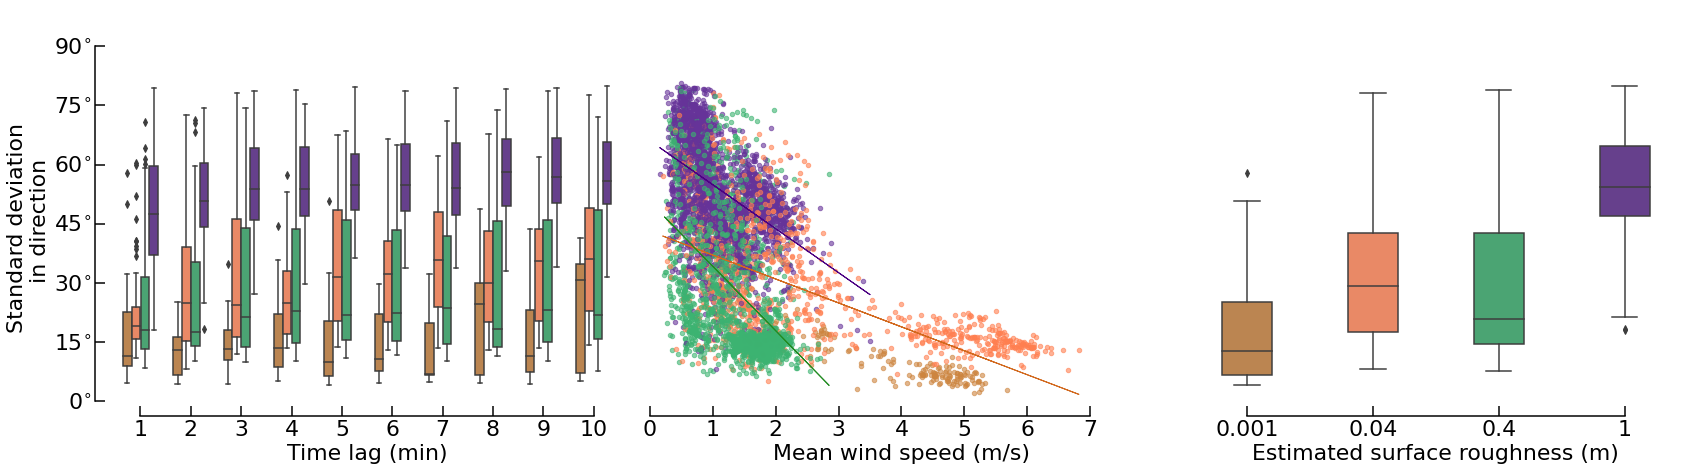

In [23]:
mpl.rcParams.update({'font.size': 22})

c=['peru', 'mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7), layout='tight')

fig.subplots_adjust(right=0.9,wspace=0.8)

ax[1].scatter(alltemp[0].speed_avg, np.abs(alltemp[0].direction_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(alltemp[1].speed_avg, np.abs(alltemp[1].direction_std),  s=20, color=c[1], alpha=.6, label='forest')
ax[1].scatter(alltemp[2].speed_avg, np.abs(alltemp[2].direction_std),  s=20, color=c[2], alpha=.6, label='urban')


for i in range(3,16):
    ax[1].scatter(alltemp[i].speed_avg, np.abs(alltemp[i].direction_std),  s=20, color=c[i], alpha=.6)

    
    
# add mean lines
slope, intercept = np.polyfit(desertchunks.speed_avg, desertchunks.direction_std, 1)
abline_values = [slope * i + intercept for i in desertchunks.speed_avg]
ax[1].plot(desertchunks.speed_avg, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.speed_avg, forestchunks.direction_std, 1)
abline_values = [slope * i + intercept for i in forestchunks.speed_avg]
ax[1].plot(forestchunks.speed_avg, abline_values, 'forestgreen', linewidth=1)
slope, intercept = np.polyfit(urbanchunks.speed_avg, urbanchunks.direction_std, 1)
abline_values = [slope * i + intercept for i in urbanchunks.speed_avg]
ax[1].plot(urbanchunks.speed_avg, abline_values, 'indigo', linewidth=1)

minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
sns.boxplot(x='time', y='direction_std', hue='environment', data=minutesdf, showfliers=True,  palette=['peru', 'coral', 'mediumseagreen', 'rebeccapurple',], width=.7, ax=ax[0])    
sns.boxplot(x=minutesdf.environment, y=minutesdf.direction_std, showfliers=True, palette=['peru', 'coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[0].get_legend().remove()
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lag (min)')


ax[0].set_ylabel('Standard deviation \n in direction')
ax[1].set_xlabel('Mean wind speed (m/s)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

ax[0].set_ylim(0,90)
ax[1].set_ylim(0,90)
ax[2].set_ylim(0,90)
ax[1].set_xlim(0,8) 

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,15, 30, 45, 60, 75, 90],
                                 #xticks=[1,100,500,1000],
                                 tick_length=10,
                                 spine_locations={'left': 20, 'bottom': 15},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=10,
                                 spine_locations={'bottom': 15},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[.001,.04, .4, 1],
                                 tick_length=10,
                                 spine_locations={ 'bottom': 15},
                                 linewidth=1.5)



evenyticks=np.arange(0, 100, 15)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax[0].set_yticklabels(yticklabels)


ax[2].set_xticklabels([.001,.04, .4, 1])

fig.savefig('regressionvariables_temporal_direction.svg', bbox_inches='tight', dpi=600, format='svg')



## speed

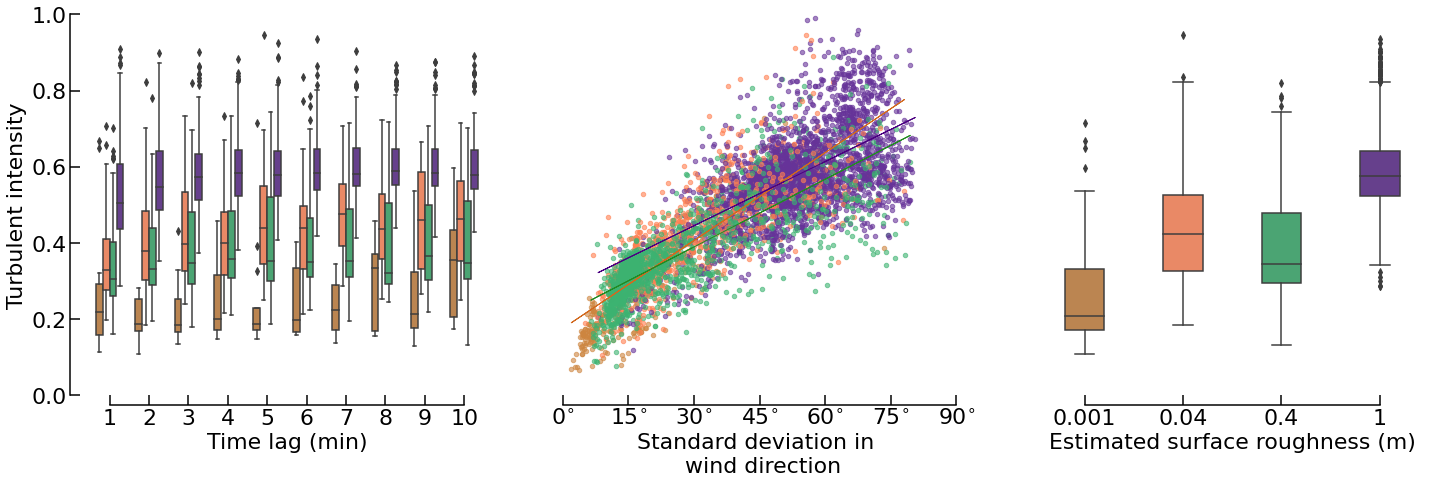

In [27]:
mpl.rcParams.update({'font.size': 22})

c=['peru', 'mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7))
ax[1].scatter(alltemp[0].direction_std, np.abs(alltemp[0].turb_intensity),  s=20, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(alltemp[1].direction_std, np.abs(alltemp[1].turb_intensity),  s=20, color=c[1], alpha=.6, label='forest')
ax[1].scatter(alltemp[2].direction_std, np.abs(alltemp[2].turb_intensity),  s=20, color=c[2], alpha=.6, label='urban')



for i in range(3,16):
    ax[1].scatter(alltemp[i].direction_std, np.abs(alltemp[i].turb_intensity),  s=20, color=c[i], alpha=.6)

    
# add mean lines
slope, intercept = np.polyfit(desertchunks.direction_std, desertchunks.turb_intensity, 1)
abline_values = [slope * i + intercept for i in desertchunks.direction_std]
ax[1].plot(desertchunks.direction_std, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.direction_std, forestchunks.turb_intensity, 1)
abline_values = [slope * i + intercept for i in forestchunks.direction_std]
ax[1].plot(forestchunks.direction_std, abline_values, 'forestgreen', linewidth=1)
slope, intercept = np.polyfit(urbanchunks.direction_std, urbanchunks.turb_intensity, 1)
abline_values = [slope * i + intercept for i in urbanchunks.direction_std]
ax[1].plot(urbanchunks.direction_std, abline_values, 'indigo', linewidth=1)
    
    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
sns.boxplot(x='time', y='turb_intensity', hue='environment', data=minutesdf, showfliers=True, palette=['peru', 'coral', 'mediumseagreen', 'rebeccapurple'], width=.7, ax=ax[0])    
sns.boxplot(x=minutesdf.environment, y=minutesdf.turb_intensity, showfliers=True, palette=['peru', 'coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[0].get_legend().remove()

ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lag (min)')

ax[2].set_xticklabels([.001,.04, .4, 1])
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[1].set_xlim(0,90) 
ax[0].set_ylabel('Turbulent intensity')
ax[1].set_xlabel('Standard deviation in \n wind direction')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                
                                 #xticks=[1,100,500,1000],
                                 tick_length=10,
                                 spine_locations={'left': 20, 'bottom':10},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,15,30,45,60,75,90],
                                 tick_length=10,
                                 spine_locations={ 'bottom':10},
                                 linewidth=1.5)



evenxticks=np.arange(0, 100, 15)
xticklabels=[['$' + str(x) + '^{\circ}$' + '',] for x in evenxticks]
xticklabels=np.ravel(yticklabels)
ax[1].set_xticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=10,
                                 spine_locations={ 'bottom': 10},
                                 linewidth=1.5)

#fig.savefig('regressionvariables_temporal_speed.svg', bbox_inches='tight', dpi=600,  format='svg')


[Text(0, 0, '$0^{\\circ}$'),
 Text(15, 0, '$15^{\\circ}$'),
 Text(30, 0, '$30^{\\circ}$'),
 Text(45, 0, '$45^{\\circ}$'),
 Text(60, 0, '$60^{\\circ}$'),
 Text(75, 0, '$75^{\\circ}$'),
 Text(90, 0, '$90^{\\circ}$')]

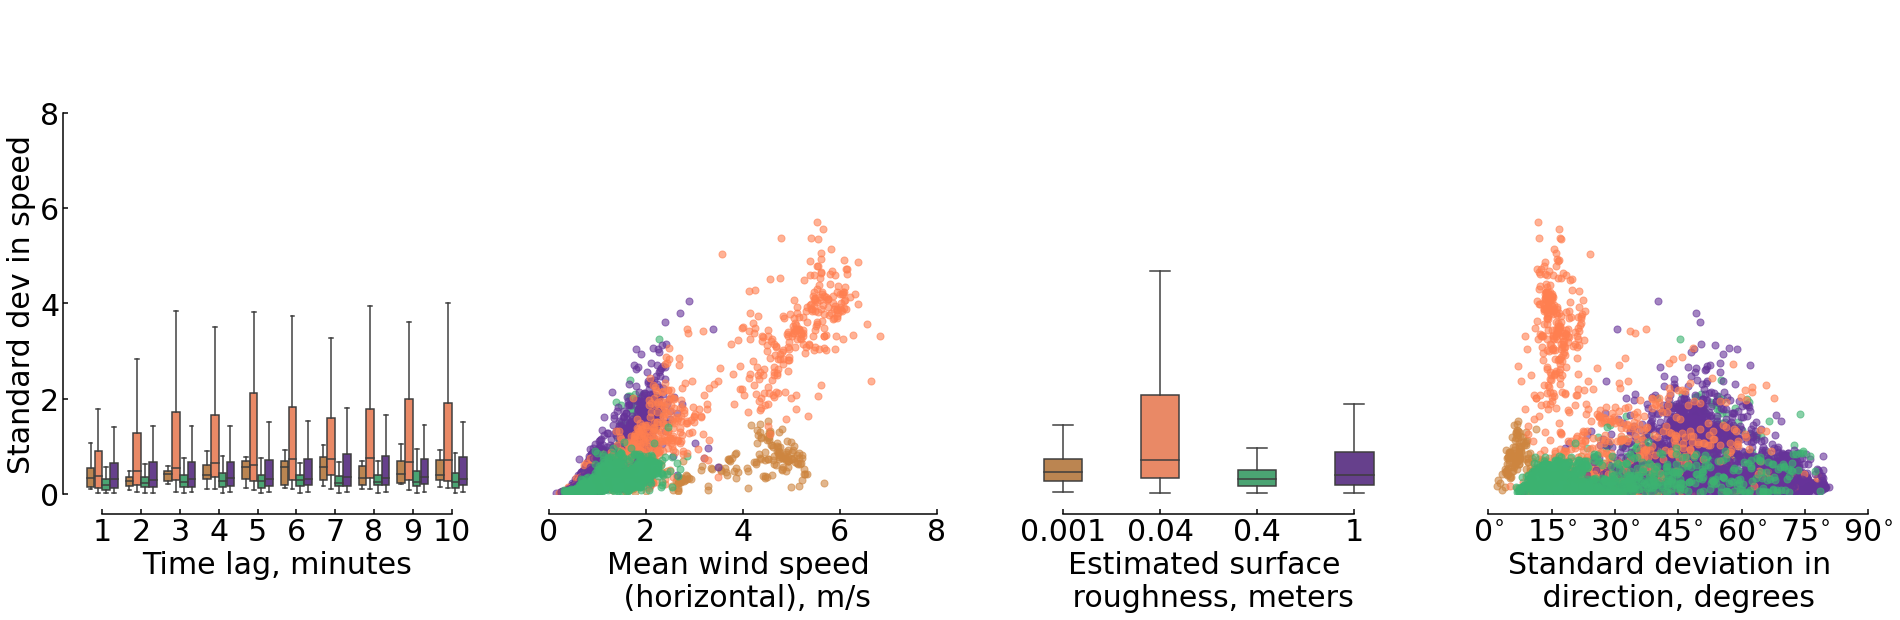

In [50]:
mpl.rcParams.update({'font.size': 30})

c=['peru','mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(32,7), rasterized=True)
#ax[1].scatter(alltemp[0].horizontal_speed_avg, np.abs(alltemp[0].vert_vel_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
#ax[1].scatter(alltemp[1].horizontal_speed_avg, np.abs(alltemp[1].vert_vel_std),  s=20, color=c[1], alpha=.6, label='forest')
#ax[1].scatter(alltemp[2].horizontal_speed_avg, np.abs(alltemp[2].vert_vel_std),  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
#ax[1].plot(deserttemp.speed_avg, abline_values_desertdirection3, 'blue', linewidth=5)
#ax[1].plot(foresttemp.speed_avg, abline_values_forestdirection3, 'darkgreen',linewidth=5)
#ax[1].plot(urbantemp.speed_avg, abline_values_urbandirection3, 'indigo', linewidth=5)


for i in range(0,16):
    ax[1].scatter(alltemp[i].speed_avg, alltemp[i].speed_std**2,  s=50, color=c[i],alpha=.6)
    ax[3].scatter(alltemp[i].direction_std,alltemp[i].speed_std**2,  s=50, color=c[i], alpha=.6)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=alltempconcat.loc[alltempconcat['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.speed_std**2, hue=minutesdf.environment, showfliers=False, palette=['peru','coral', 'mediumseagreen', 'rebeccapurple',], width=.8, ax=ax[0])    
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time lags, minutes')
ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=alltempconcat.environment, y=alltempconcat.speed_std**2, showfliers=False, palette=['peru','coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)
ax[2].set_xticklabels([.001, .04, .4, 1])
ax[0].set_ylabel('Standard dev in speed')
ax[0].set_xlabel('Time lag, minutes')  
ax[1].set_xlabel('Mean wind speed \n (horizontal), m/s')
ax[2].set_ylabel('')
ax[3].set_xlabel('Standard deviation in \n direction, degrees')
ax[2].set_xlabel('Estimated surface \n roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

ax[0].set_ylim(0,2.5**2)
ax[1].set_ylim(0,2.5**2)
ax[2].set_ylim(0,2.5**2)
ax[3].set_ylim(0,2.5**2)
ax[1].set_xlim(0,7)
# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                #yticks=np.arange(0,17,2)/10,
                                 #xticks=[1,100,500,1000],
                                 tick_length=5,
                                 spine_locations={'left': 20, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=5,
                                 spine_locations={'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=5,
                                 spine_locations={'bottom': 20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 xticks=[0,15,30,45,60,75,90],
                                 tick_length=5,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)
evenxticks=np.arange(0, 100, 15)
xticklabels=[['$' + str(x) + '^{\circ}$' + '',] for x in evenxticks]
xticklabels=np.ravel(xticklabels)
ax[3].set_xticklabels(xticklabels)



#fig.savefig('regression_verticalratio.svg', bbox_inches='tight', format='svg')



# Regression analysis

In [28]:
alltemporal=alltempconcat

In [ ]:
alltemporal=pd.read_hdf('all_temporal.hdf', key='/windgps')
alltemporal

In [29]:
#normalize pandas columns
N=len(alltemporal)+1
normalized_data = alltemporal.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

In [30]:
normalized_data

,index,time,speed_std,direction_std,speed_avg,direction_avg,group,environment,turb_intensity,sin_direction_avg,cos_direction_avg,log_direction_std,log_direction_avg,log_speed_std,log_speed_avg
0,-1.228202,-1.605736,-0.879779,-0.507657,-0.216296,-0.301619,-1.776175,-1.483885,-1.326293,0.447462,-1.390937,-0.201777,0.066878,-0.936171,0.039969
1,-1.222640,-1.495177,-0.162374,-1.826655,3.514240,-0.050508,-1.776175,-1.483885,-2.235564,-0.071384,-1.263602,-3.745659,0.204491,0.093039,2.395703
2,-1.217079,-1.329339,0.293005,-1.657056,3.342069,-0.137313,-1.776175,-1.483885,-2.019891,0.102934,-1.333916,-2.588946,0.158661,0.533013,2.336754
3,-1.211517,-1.163500,-0.167113,-1.757269,3.572894,-0.108618,-1.776175,-1.483885,-2.245374,0.044471,-1.313673,-3.168045,0.174003,0.087847,2.415313
4,-1.205956,-0.997662,-0.786773,-0.718123,-0.109329,-0.226420,-1.776175,-1.483885,-1.313716,0.288338,-1.377416,-0.445407,0.109747,-0.764788,0.183396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,0.145489,0.992397,-0.061881,0.134055,-0.280480,-1.807515,1.519696,-0.467896,0.225164,1.561641,1.335264,0.369989,-1.475018,0.199753,-0.052482
5771,0.151050,1.158236,0.183435,0.627597,-0.397361,0.153744,1.519696,-0.467896,1.081330,-0.440219,-0.997154,0.701829,0.305968,0.436517,-0.235411
5772,0.156612,1.324074,0.217819,-0.062275,0.040163,-1.005264,1.519696,-0.467896,-0.086426,1.687213,-0.558356,0.215887,-0.430607,0.467356,0.365020
5773,0.162173,1.489912,-0.336426,0.813522,-0.300768,-0.844637,1.519696,-0.467896,-0.216129,1.482274,-0.880375,0.810783,-0.297810,-0.108144,-0.082816


## direction

In [31]:
mod = smf.gls(formula='direction_std ~ environment*speed_avg + speed_avg*time', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:          direction_std   R-squared:                       0.520
Model:                            GLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     147.0
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           3.42e-12
Time:                        23:55:28   Log-Likelihood:                -6076.4
No. Observations:                5775   AIC:                         1.216e+04
Df Residuals:                    5769   BIC:                         1.220e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.10

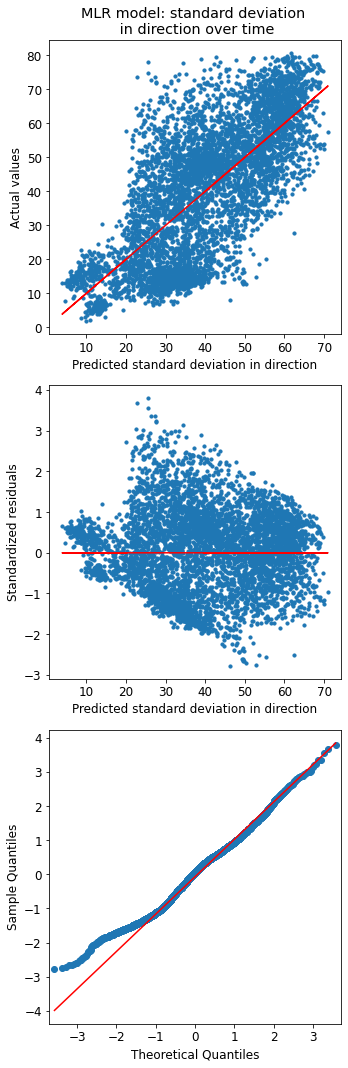

In [32]:
mod = smf.gls(formula='direction_std ~ environment*speed_avg + speed_avg*time', data=alltemporal)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight', rasterized=True)


slope, intercept = np.polyfit(res.fittedvalues, alltemporal.direction_std, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: standard deviation \n in direction over time')
ax[0].scatter(res.fittedvalues, alltemporal.direction_std, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted standard deviation in direction')
ax[0].set_ylabel ('Actual values')
#ax[0].set_xlim(-5,90)
#ax[0].set_ylim(-5,90)

slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted standard deviation in direction')
ax[1].set_ylabel ('Standardized residuals')


sm.qqplot(res.resid_pearson, line='q', ax=ax[2])
plt.show()

fig.savefig('regressionresidualtests_direction.svg', dpi=600, format='svg')


## speed

In [33]:
mod = smf.gls(formula='turb_intensity ~ environment*direction_std + direction_std*time', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:         turb_intensity   R-squared:                       0.714
Model:                            GLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     98.70
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           6.24e-11
Time:                        23:57:20   Log-Likelihood:                -4581.2
No. Observations:                5775   AIC:                             9174.
Df Residuals:                    5769   BIC:                             9214.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

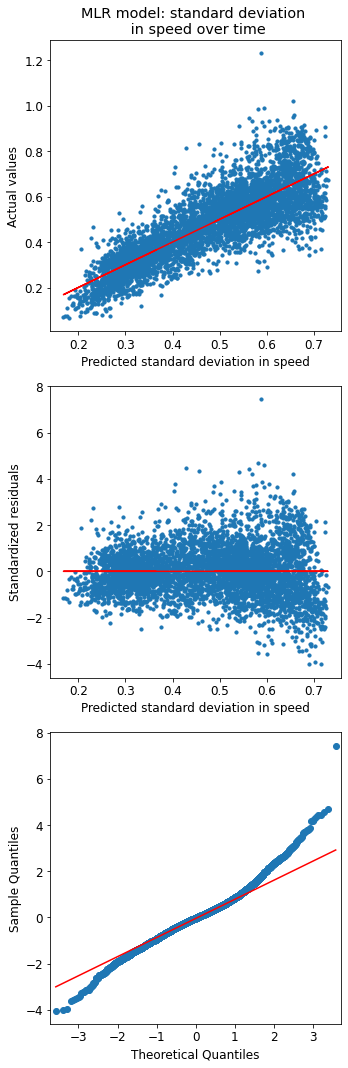

In [34]:
mod = smf.gls(formula='turb_intensity ~ environment*direction_std + time*direction_std', data=alltemporal)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight',rasterized=True)


slope, intercept = np.polyfit(res.fittedvalues, alltemporal.turb_intensity, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: standard deviation \n in speed over time')
ax[0].scatter(res.fittedvalues, alltemporal.turb_intensity, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted standard deviation in speed')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted standard deviation in speed')
ax[1].set_ylabel ('Standardized residuals')


sm.qqplot(res.resid_pearson, line='q', ax=ax[2])
plt.show()

fig.savefig('regressionresidualtests_speed.svg', dpi=600, format='svg')

